In [1]:
# Импорт всех необходимых библиотек
import torch as pt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import os
import tqdm as tqdm
import time
from google.colab import drive
from joblib import Memory
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report


In [2]:

# Монтируем Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cachedir = '/content/cache/'
memory = Memory(cachedir, verbose=0, compress=True)
memory.clear(warn=False)

In [4]:
# Установка случайных seed для воспроизводимости результатов
random_seed = 42

random.seed(random_seed)
np.random.seed(random_seed)
pt.manual_seed(random_seed)
pt.cuda.manual_seed(random_seed)
pt.cuda.manual_seed_all(random_seed)
pt.backends.cudnn.deterministic = True

# Определение устройства (GPU/CPU)
if pt.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: cuda


In [5]:
# Распаковка датасета
!unzip -u "drive/MyDrive/AudioDataset_Classification.zip" -d "/content/dataset"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/dataset/AudioDataset_Classification/ZLRC/Drone ABC_C_F_MF2_mic1_710_EoeunHill_682_snr=14294721851857481_mic1_1.wav  
  inflating: /content/dataset/AudioDataset_Classification/ZLRC/Drone ABC_C_F_MF2_mic1_721_ConstructionSite_221_snr=14070084838437408_mic1_1.wav  
  inflating: /content/dataset/AudioDataset_Classification/ZLRC/Drone ABC_C_F_MF2_mic1_730_EoeunHill_746_snr=1433818900326608_mic1_1.wav  
  inflating: /content/dataset/AudioDataset_Classification/ZLRC/Drone ABC_C_F_MF2_mic1_73_SportsComplex_409_snr=1406852831293006_mic1_1.wav  
  inflating: /content/dataset/AudioDataset_Classification/ZLRC/Drone ABC_C_F_MF2_mic1_741_ConstructionSite_464_snr=14505148627736702_mic1_1.wav  
  inflating: /content/dataset/AudioDataset_Classification/ZLRC/Drone ABC_C_F_MF2_mic1_744_EoeunHill_791_snr=14352919706079412_mic1_1.wav  
  inflating: /content/dataset/AudioDataset_Classification/ZLRC/Drone ABC_C_F_MF2_mi

In [6]:
# %%
# Конфигурация параметров
dataset_directory = '/content/dataset/AudioDataset_Classification'
duration = 0.5  # Загружаем по 0,5 секунд из каждого файла

classes_list = ["Background", "Bebop", "HolyStone", "Mambo", "Mavic", "MJX", "Race", "X5", "ZLRC"]

# ОПТИМИЗИРОВАННЫЕ ГИПЕРПАРАМЕТРЫ
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
DROPOUT_RATE = 0.3

print("Configuration:")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Weight Decay: {WEIGHT_DECAY}")
print(f"Dropout Rate: {DROPOUT_RATE}")

Configuration:
Batch Size: 32
Epochs: 30
Learning Rate: 0.001
Weight Decay: 0.0001
Dropout Rate: 0.3


In [7]:
# Функции предварительной обработки данных
@memory.cache
def preprocess_file(filename, duration):
    """Загрузка и предварительная обработка аудиофайла"""
    waveform, sr = librosa.load(filename, sr=16_000, offset=0.0, duration=duration)
    waveform = normalize(waveform)
    waveform = melspectrogram(waveform, sr)
    return waveform

def normalize(waveform):
    """Нормализация сигнала к нулевому среднему и единичной дисперсии"""
    s = waveform.astype(np.float32) - np.mean(waveform)
    std = np.std(s)
    s = s / std
    return s

def melspectrogram(waveform, sr):
    """Построение мелспектрограммы"""
    librosa_melspectrogram = librosa.feature.melspectrogram(
        y=waveform, sr=sr, n_fft=512, hop_length=256, n_mels=64, pad_mode='constant'
    )
    return librosa_melspectrogram

In [8]:
# Класс датасета
class DroneDataset(Dataset):
    def __init__(self, dataset_dir, duration, device):
        files_list = []

        for i in range(len(classes_list)):
            drone_files = os.listdir(os.path.join(os.path.realpath(dataset_dir), classes_list[i]))
            for filename in drone_files:
                if filename.endswith(".wav"):
                    fname = os.path.join(os.path.realpath(dataset_dir), classes_list[i], filename)
                    y, sr = librosa.load(fname, sr=16_000, offset=0.0, duration=duration)
                    # Проверка корректности аудио
                    if librosa.util.valid_audio(y) and not all(x==y[0] for x in y):
                        label = i
                        files_list.append((fname, label))

        self.datalist = files_list
        self.duration = duration
        self.device = device

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        waveform = preprocess_file(self.datalist[idx][0], self.duration)
        waveform = pt.from_numpy(np.expand_dims(waveform, axis=0))
        waveform = waveform.to(device)
        return waveform, float(self.datalist[idx][1])

In [9]:
# Создание датасета и разделение на train/val/test
print("Creating dataset...")
all_dataset = DroneDataset(dataset_directory, duration, device)

total_count = len(all_dataset)
train_count = int(0.7 * total_count)
valid_count = int(0.15 * total_count)
test_count = total_count - train_count - valid_count

train_dataset, val_dataset, test_dataset = pt.utils.data.random_split(
    all_dataset, (train_count, valid_count, test_count)
)

train_data_size = len(train_dataset)
val_data_size = len(val_dataset)
test_data_size = len(test_dataset)

print(f"Dataset sizes - Train: {train_data_size}, Val: {val_data_size}, Test: {test_data_size}")


Creating dataset...
Dataset sizes - Train: 45167, Val: 9678, Test: 9680


In [10]:
# Создание DataLoader'ов
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders created successfully!")


DataLoaders created successfully!


In [11]:
# ОПТИМИЗИРОВАННАЯ АРХИТЕКТУРА CNN
class CNNNetwork(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()

        # Блок 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout2d(p=dropout_rate)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2)
        )

        # Блок 2
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout2d(p=dropout_rate)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2)
        )

        # Блок 3
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout2d(p=dropout_rate)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2)
        )

        # Блок 4
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout2d(p=dropout_rate)
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.flatten = nn.Flatten()

        # Полносвязные слои
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=256*4*4, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.1),

            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=512, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.1),

            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=256, out_features=len(classes_list))
        )

        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)

        x = self.flatten(x)
        x = self.classifier(x)
        output = self.logSoftmax(x)

        return output

In [12]:
# Создание модели
print("Creating model...")
model = CNNNetwork(dropout_rate=DROPOUT_RATE).to(device)

# Вывод архитектуры модели
print("Model architecture:")
summary(model, (1, 64, 32))


Creating model...
Model architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 32]             320
       BatchNorm2d-2           [-1, 32, 64, 32]              64
         LeakyReLU-3           [-1, 32, 64, 32]               0
         Dropout2d-4           [-1, 32, 64, 32]               0
            Conv2d-5           [-1, 32, 64, 32]           9,248
       BatchNorm2d-6           [-1, 32, 64, 32]              64
         LeakyReLU-7           [-1, 32, 64, 32]               0
         MaxPool2d-8           [-1, 32, 32, 16]               0
            Conv2d-9           [-1, 64, 32, 16]          18,496
      BatchNorm2d-10           [-1, 64, 32, 16]             128
        LeakyReLU-11           [-1, 64, 32, 16]               0
        Dropout2d-12           [-1, 64, 32, 16]               0
           Conv2d-13           [-1, 64, 32, 16]          36,928
 

In [13]:


# Настройка функции потерь, оптимизатора и scheduler'а
loss_func = nn.NLLLoss()

optimizer = pt.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)


scheduler = pt.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print("Loss function, optimizer and scheduler configured!")

Loss function, optimizer and scheduler configured!


In [14]:
# ФУНКЦИЯ ОБУЧЕНИЯ С РАННЕЙ ОСТАНОВКОЙ
def train_and_validate(model, loss_criterion, optimizer, scheduler, epochs=30, patience=7):

    history = []
    best_loss = float('inf')
    best_epoch = None
    best_model_state = None
    patience_counter = 0
    previous_lr = LEARNING_RATE  # Сохраняем начальный learning rate

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch + 1, epochs))

        # Обучение
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels.to(pt.int64))
            loss.backward()

            # Gradient clipping
            pt.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predictions = pt.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = pt.mean(correct_counts.type(pt.FloatTensor))
            train_acc += acc.item() * inputs.size(0)

        # Валидация
        model.eval()
        valid_loss = 0.0
        valid_acc = 0.0

        with pt.no_grad():
            for j, (inputs, labels) in enumerate(val_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_criterion(outputs, labels.to(pt.int64))
                valid_loss += loss.item() * inputs.size(0)

                _, predictions = pt.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = pt.mean(correct_counts.type(pt.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)

        # Расчет средних метрик
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / val_data_size
        avg_valid_acc = valid_acc / val_data_size

        # Сохраняем текущий LR до обновления scheduler
        current_lr_before = optimizer.param_groups[0]['lr']

        # Обновление learning rate
        scheduler.step(avg_valid_loss)

        # Получаем текущий LR после обновления
        current_lr = optimizer.param_groups[0]['lr']

        # Ручной вывод информации об изменении learning rate
        if epoch > 0 and current_lr < current_lr_before:
            print(f"Learning rate reduced from {current_lr_before:.6f} to {current_lr:.6f}")

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc, current_lr])

        # Ранняя остановка
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            best_epoch = epoch
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            pt.save(model.state_dict(), f'best_model_epoch_{epoch}.pt')
            print("*** New best model saved! ***")
        else:
            patience_counter += 1

        epoch_end = time.time()

        print(f"Epoch: {epoch:03d}, LR: {current_lr:.6f}")
        print(f"Training: Loss - {avg_train_loss:.5f}, Accuracy - {avg_train_acc:.5f}")
        print(f"Validation: Loss - {avg_valid_loss:.5f}, Accuracy - {avg_valid_acc:.5f}")
        print(f"Time: {epoch_end - epoch_start:.2f}s")

        # Вывод информации о patience
        if patience_counter > 0:
            print(f"Patience counter: {patience_counter}/{patience}")

        print("-" * 60)

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    # Загрузка лучшей модели
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    else:
        print("Warning: No best model state found. Using final model.")

    return model, history, best_epoch

In [15]:
# ЗАПУСК ОБУЧЕНИЯ
print("Starting training...")
trained_model, history, best_epoch = train_and_validate(
    model, loss_func, optimizer, scheduler, NUM_EPOCHS
)

print(f"Training completed! Best epoch: {best_epoch + 1}")


Starting training...
Epoch: 1/30
*** New best model saved! ***
Epoch: 000, LR: 0.001000
Training: Loss - 0.49284, Accuracy - 0.81117
Validation: Loss - 0.13159, Accuracy - 0.95485
Time: 325.75s
------------------------------------------------------------
Epoch: 2/30
*** New best model saved! ***
Epoch: 001, LR: 0.001000
Training: Loss - 0.19779, Accuracy - 0.93522
Validation: Loss - 0.10461, Accuracy - 0.96497
Time: 55.75s
------------------------------------------------------------
Epoch: 3/30
*** New best model saved! ***
Epoch: 002, LR: 0.001000
Training: Loss - 0.15178, Accuracy - 0.95021
Validation: Loss - 0.08121, Accuracy - 0.97313
Time: 54.88s
------------------------------------------------------------
Epoch: 4/30
*** New best model saved! ***
Epoch: 003, LR: 0.001000
Training: Loss - 0.13147, Accuracy - 0.95742
Validation: Loss - 0.07498, Accuracy - 0.97675
Time: 55.22s
------------------------------------------------------------
Epoch: 5/30
*** New best model saved! ***
Epoc

In [16]:
# СОХРАНЕНИЕ МОДЕЛИ
pt.save(trained_model.state_dict(), 'drive/My Drive/CNN_classify_model_best.pt')
print("Best model saved to Google Drive!")


Best model saved to Google Drive!


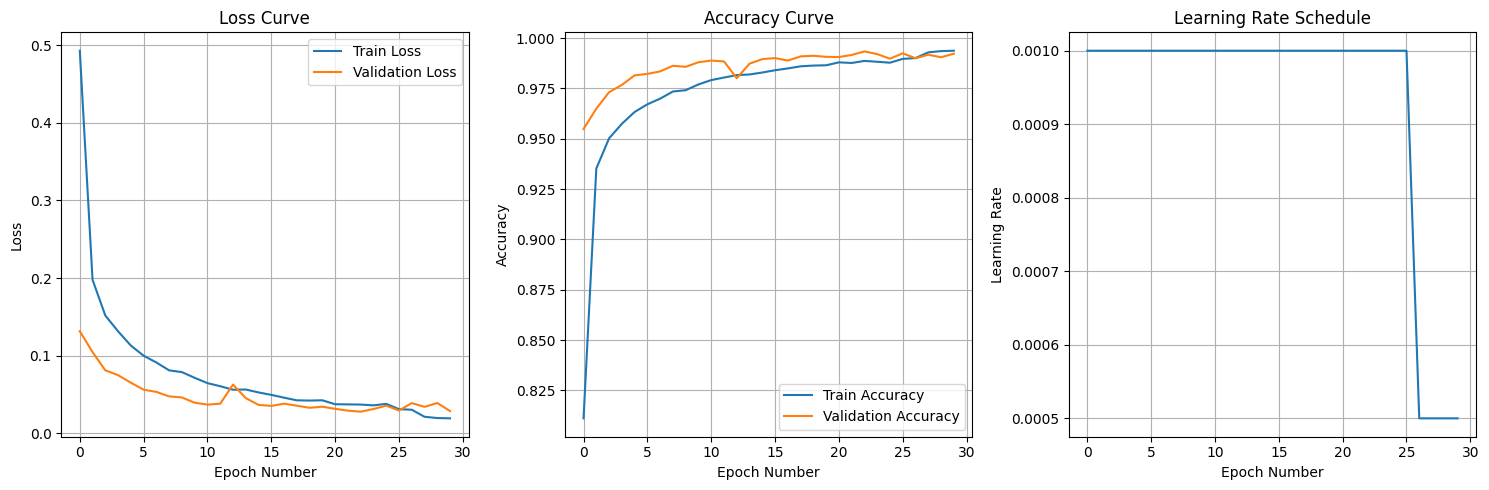

In [17]:
# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ
history = np.array(history)

plt.figure(figsize=(15, 5))

# График потерь
plt.subplot(1, 3, 1)
plt.plot(history[:, 0], label='Train Loss')
plt.plot(history[:, 1], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)

# График точности
plt.subplot(1, 3, 2)
plt.plot(history[:, 2], label='Train Accuracy')
plt.plot(history[:, 3], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)

# График learning rate
plt.subplot(1, 3, 3)
plt.plot(history[:, 4])
plt.xlabel('Epoch Number')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# ФУНКЦИЯ ТЕСТИРОВАНИЯ МОДЕЛИ
def computeTestSetAccuracy(model, loss_criterion):
    model.eval()
    test_acc = 0.0
    test_loss = 0.0
    true_labels = []
    pred_labels = []

    with pt.no_grad():
        for j, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_criterion(outputs, labels.to(pt.int64))
            test_loss += loss.item() * inputs.size(0)

            _, predictions = pt.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = pt.mean(correct_counts.type(pt.FloatTensor))
            test_acc += acc.item() * inputs.size(0)

            true_labels.extend(labels.cpu().numpy().astype(int).tolist())
            pred_labels.extend(predictions.cpu().numpy().astype(int).tolist())

    avg_test_loss = test_loss / test_data_size
    avg_test_acc = test_acc / test_data_size

    print(f"Test accuracy: {avg_test_acc:.5f}")
    print(f"Test loss: {avg_test_loss:.5f}")

    return true_labels, pred_labels, avg_test_acc, avg_test_loss


In [19]:
# ТЕСТИРОВАНИЕ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ
print("Testing model on test set...")
true_labels, pred_labels, test_accuracy, test_loss = computeTestSetAccuracy(trained_model, loss_func)


Testing model on test set...
Test accuracy: 0.99153
Test loss: 0.02709


In [20]:
# ДЕТАЛЬНЫЕ МЕТРИКИ КАЧЕСТВА
print('\n=== DETAILED METRICS ===')
print('Accuracy: {:.5f}'.format(accuracy_score(true_labels, pred_labels)))
print('Macro F1: {:.5f}'.format(f1_score(true_labels, pred_labels, average="macro")))
print('Weighted F1: {:.5f}'.format(f1_score(true_labels, pred_labels, average="weighted")))
print('Macro Precision: {:.5f}'.format(precision_score(true_labels, pred_labels, average="macro")))
print('Macro Recall: {:.5f}'.format(recall_score(true_labels, pred_labels, average="macro")))



=== DETAILED METRICS ===
Accuracy: 0.99153
Macro F1: 0.98281
Weighted F1: 0.99156
Macro Precision: 0.98121
Macro Recall: 0.98458


In [21]:
# ОТЧЕТ КЛАССИФИКАЦИИ
print('\n=== CLASSIFICATION REPORT ===')
print(classification_report(true_labels, pred_labels, target_names=classes_list))


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

  Background       0.99      0.99      0.99      2241
       Bebop       0.98      0.96      0.97       181
   HolyStone       1.00      1.00      1.00      1677
       Mambo       0.89      0.94      0.91       177
       Mavic       1.00      1.00      1.00      1271
         MJX       1.00      0.99      0.99      1648
        Race       0.99      1.00      0.99       388
          X5       1.00      1.00      1.00       480
        ZLRC       0.99      0.99      0.99      1617

    accuracy                           0.99      9680
   macro avg       0.98      0.98      0.98      9680
weighted avg       0.99      0.99      0.99      9680



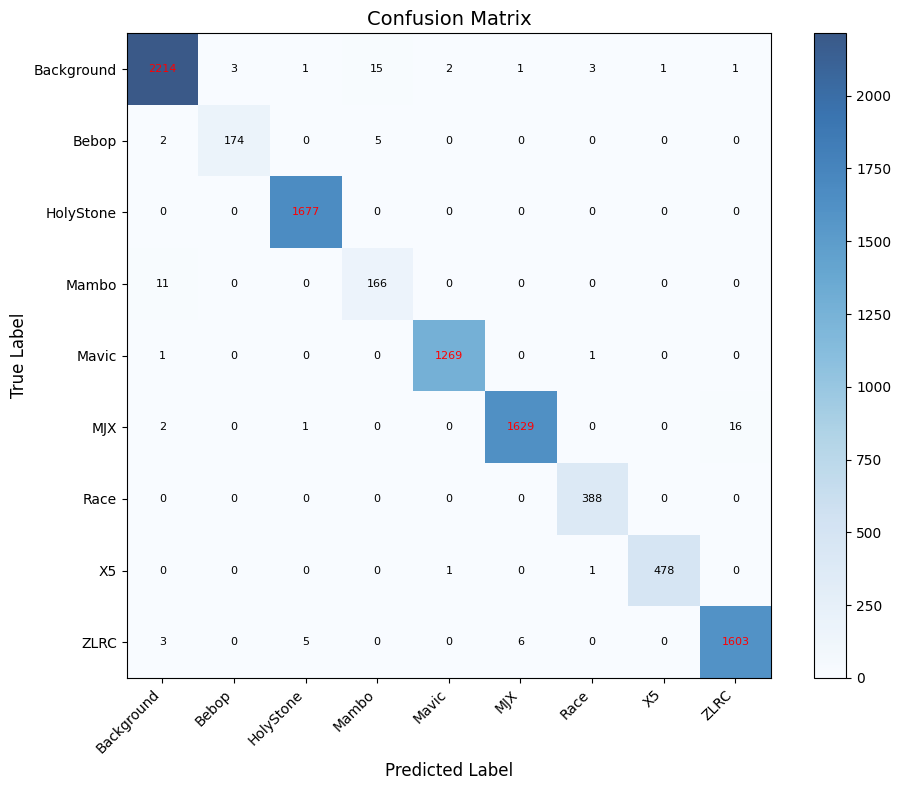

In [22]:
# MATРИЦА ОШИБОК
confmat = confusion_matrix(y_true=true_labels, y_pred=pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(confmat, cmap=plt.cm.Blues, alpha=0.8)
plt.colorbar()

plt.xticks(range(len(classes_list)), classes_list, rotation=45, ha='right')
plt.yticks(range(len(classes_list)), classes_list)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        plt.text(j, i, str(confmat[i, j]),
                ha='center', va='center',
                color='red' if confmat[i, j] > confmat.max()/2 else 'black',
                fontsize=8)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [23]:
# ФУНКЦИЯ ДЛЯ ПРЕДСКАЗАНИЯ НА ОДНОМ ПРИМЕРЕ
def predict_single_sample(model, sample_index=0):
    """Предсказание для одного примера из тестовой выборки"""
    waveform, true_label = test_dataset[sample_index]
    model.eval()

    with pt.no_grad():
        # Добавляем dimension батча
        inputs = pt.unsqueeze(waveform, 0)
        outputs = model(inputs)
        probabilities = pt.exp(outputs)  # Преобразуем log probabilities в probabilities

    predicted_class = pt.argmax(probabilities, dim=1).item()
    confidence = probabilities[0][predicted_class].item()

    print(f"True label: {classes_list[int(true_label)]} ({int(true_label)})")
    print(f"Predicted label: {classes_list[predicted_class]} ({predicted_class})")
    print(f"Confidence: {confidence:.4f}")

    # Вывод вероятностей для всех классов
    print("\nProbabilities for all classes:")
    for i, prob in enumerate(probabilities[0]):
        print(f"  {classes_list[i]}: {prob:.4f}")

    return probabilities, predicted_class, int(true_label)

In [24]:
# ПРИМЕР ПРЕДСКАЗАНИЯ ДЛЯ ОДНОГО СЕМПЛА
print("Single sample prediction:")
probs, pred_class, true_class = predict_single_sample(trained_model, sample_index=0)


Single sample prediction:
True label: ZLRC (8)
Predicted label: ZLRC (8)
Confidence: 1.0000

Probabilities for all classes:
  Background: 0.0000
  Bebop: 0.0000
  HolyStone: 0.0000
  Mambo: 0.0000
  Mavic: 0.0000
  MJX: 0.0000
  Race: 0.0000
  X5: 0.0000
  ZLRC: 1.0000


In [25]:
# СОХРАНЕНИЕ ИСТОРИИ ОБУЧЕНИЯ
np.save('training_history.npy', history)
print("Training history saved!")


Training history saved!


In [26]:
# ФИНАЛЬНЫЙ ОТЧЕТ
print("\n" + "="*50)
print("FINAL TRAINING REPORT")
print("="*50)
print(f"Best epoch: {best_epoch + 1}")
print(f"Final test accuracy: {test_accuracy:.4f}")
print(f"Final test loss: {test_loss:.4f}")
print(f"Number of classes: {len(classes_list)}")
print(f"Classes: {', '.join(classes_list)}")
print("="*50)


FINAL TRAINING REPORT
Best epoch: 23
Final test accuracy: 0.9915
Final test loss: 0.0271
Number of classes: 9
Classes: Background, Bebop, HolyStone, Mambo, Mavic, MJX, Race, X5, ZLRC



ЗАПУСК ПРАВИЛЬНОГО ТЕСТИРОВАНИЯ УСТОЙЧИВОСТИ

ОТЛАДОЧНАЯ ИНФОРМАЦИЯ О ДАННЫХ

Пример 0:
  Форма: (64, 32)
  Метка: 8.0 -> ZLRC
  Минимальное значение: 0.034423
  Максимальное значение: 920.941345
  Среднее значение: 16.104744
  Стандартное отклонение: 70.750397
  Предсказание: ZLRC (уверенность: 1.0000)
  Правильно: True

Пример 1:
  Форма: (64, 32)
  Метка: 5.0 -> MJX
  Минимальное значение: 0.007272
  Максимальное значение: 747.359863
  Среднее значение: 15.715569
  Стандартное отклонение: 68.340256
  Предсказание: MJX (уверенность: 1.0000)
  Правильно: True

Пример 2:
  Форма: (64, 32)
  Метка: 2.0 -> HolyStone
  Минимальное значение: 0.010967
  Максимальное значение: 1152.790283
  Среднее значение: 15.574403
  Стандартное отклонение: 86.922188
  Предсказание: HolyStone (уверенность: 1.0000)
  Правильно: True

ДЕТАЛЬНАЯ ВИЗУАЛИЗАЦИЯ ЭФФЕКТОВ ШУМА:
Оригинал: ZLRC -> ZLRC (уверенность: 1.0000)


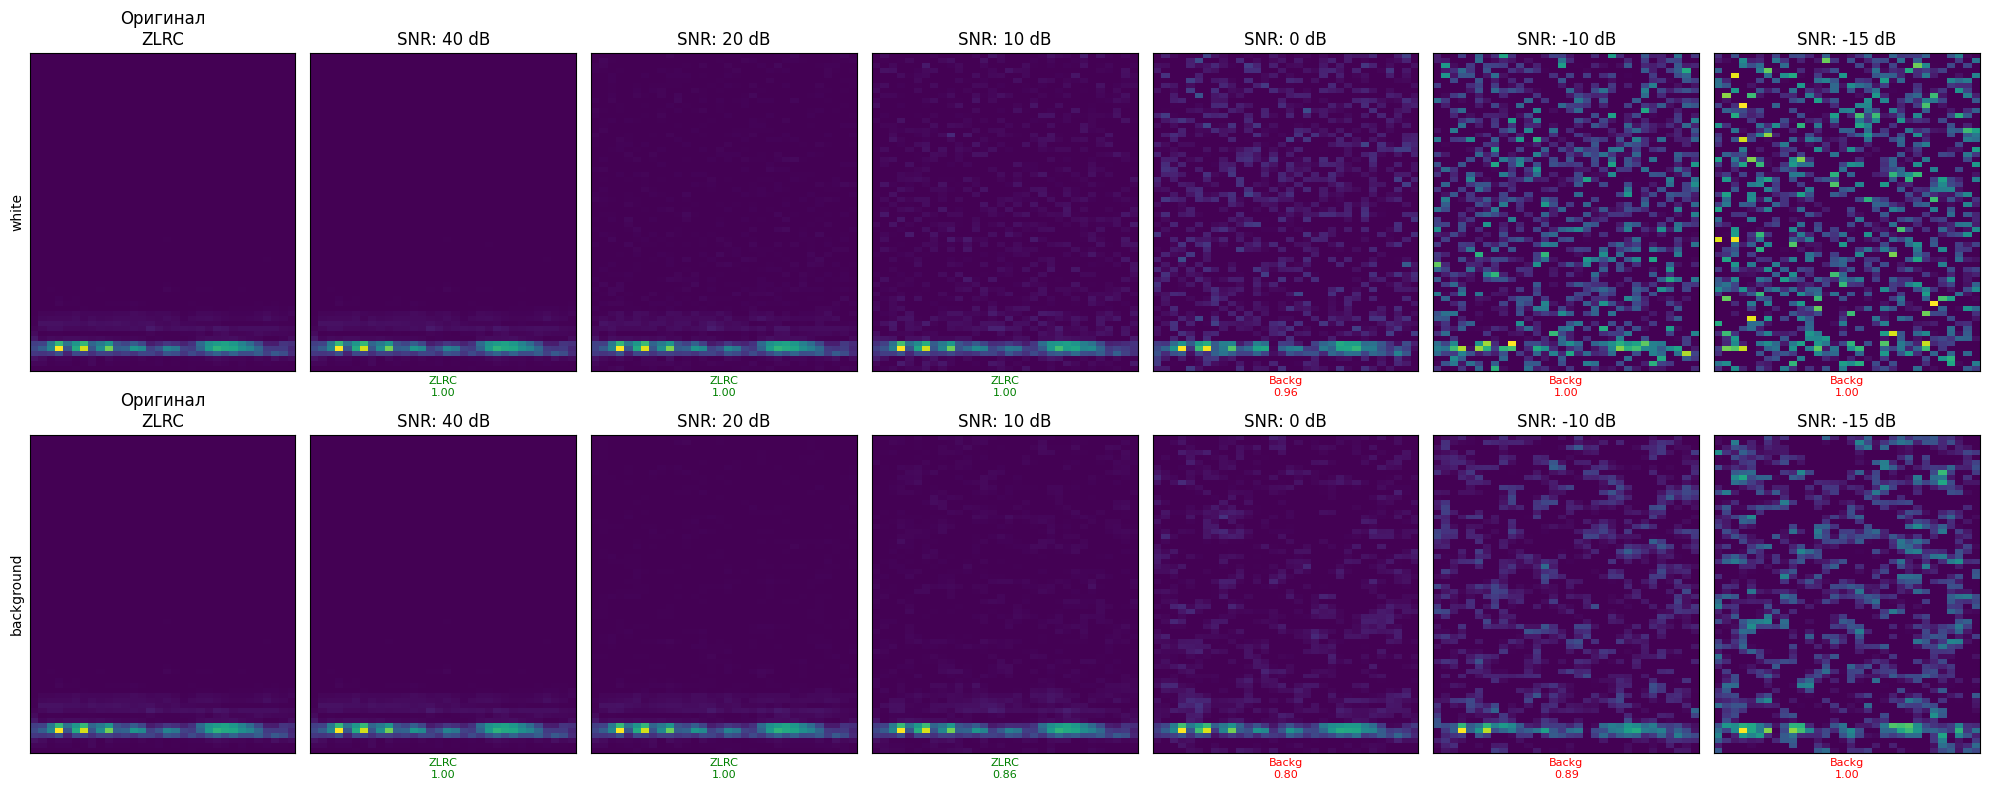


АНАЛИЗ ЧУВСТВИТЕЛЬНОСТИ МОДЕЛИ
Точность на чистых данных: 0.9915

Тестирование при высоких SNR:
SNR 60 dB: Средняя точность = 0.9904
SNR 50 dB: Средняя точность = 0.9837
SNR 40 dB: Средняя точность = 0.9428
SNR 30 dB: Средняя точность = 0.8506

3. ОСНОВНОЕ ТЕСТИРОВАНИЕ УСТОЙЧИВОСТИ:

ПРАВИЛЬНОЕ ТЕСТИРОВАНИЕ УСТОЙЧИВОСТИ К ШУМАМ
Тестирование на чистых данных...

Точность на чистых данных: 0.9915

--- Тестирование с шумом: white ---
  SNR: 40 dB
  Точность: 0.9331
  SNR: 30 dB
  Точность: 0.8331
  SNR: 20 dB
  Точность: 0.7468
  SNR: 15 dB
  Точность: 0.7098
  SNR: 10 dB
  Точность: 0.6251
  SNR: 5 dB
  Точность: 0.4437
  SNR: 0 dB
  Точность: 0.3262
  SNR: -5 dB
  Точность: 0.2558
  SNR: -10 dB
  Точность: 0.2327
  SNR: -15 dB
  Точность: 0.2315

--- Тестирование с шумом: background ---
  SNR: 40 dB
  Точность: 0.9537
  SNR: 30 dB
  Точность: 0.8723
  SNR: 20 dB
  Точность: 0.7668
  SNR: 15 dB
  Точность: 0.7152
  SNR: 10 dB
  Точность: 0.6129
  SNR: 5 dB
  Точность: 0.4468
  SNR: 0 dB

In [ ]:
# ПЕРЕРАБОТАННЫЙ КОД С ПРАВИЛЬНЫМ ДОБАВЛЕНИЕМ ШУМА
import numpy as np
import matplotlib.pyplot as plt

# ПРАВИЛЬНАЯ РЕАЛИЗАЦИЯ ДОБАВЛЕНИЯ ШУМА К МЕЛ-СПЕКТРОГРАММАМ
class CorrectedNoisyDroneDataset(Dataset):
    def __init__(self, original_dataset, noise_type, snr_db):
        self.original_dataset = original_dataset
        self.noise_type = noise_type
        self.snr_db = snr_db

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        waveform, label = self.original_dataset[idx]

        # Применяем шум с правильным расчетом
        noisy_waveform = self.add_proper_noise(waveform, self.noise_type, self.snr_db)

        return noisy_waveform, label

    def add_proper_noise(self, melspectrogram, noise_type, snr_db):
        """Правильное добавление шума к мел-спектрограммам"""
        # Получаем исходную мел-спектрограмму
        mel_np = melspectrogram.cpu().numpy().squeeze().astype(np.float32)

        # Рассчитываем мощность сигнала
        signal_power = np.mean(mel_np ** 2)

        # Рассчитываем требуемую мощность шума на основе SNR
        snr_linear = 10 ** (snr_db / 10)
        noise_power = signal_power / snr_linear

        if noise_type == 'white':
            # Белый гауссовский шум
            noise_std = np.sqrt(noise_power)
            noise = np.random.normal(0, noise_std, mel_np.shape).astype(np.float32)
            noisy_mel = mel_np + noise

        elif noise_type == 'background':
            # Цветной шум с низкочастотным характером
            noise_std = np.sqrt(noise_power)
            base_noise = np.random.normal(0, noise_std, mel_np.shape).astype(np.float32)

            # Создаем низкочастотный фильтр
            rows, cols = mel_np.shape
            y_freq = np.fft.fftfreq(rows)
            x_freq = np.fft.fftfreq(cols)
            Y, X = np.meshgrid(y_freq, x_freq, indexing='ij')

            # Низкочастотный фильтр (усиливаем низкие частоты)
            freq_filter = 1.0 / (1.0 + 10 * (Y**2 + X**2))
            freq_filter = freq_filter / np.max(freq_filter)

            # Применяем фильтр к шуму через FFT
            noise_fft = np.fft.fft2(base_noise)
            filtered_noise_fft = noise_fft * freq_filter
            noise = np.real(np.fft.ifft2(filtered_noise_fft))

            noisy_mel = mel_np + noise

        elif noise_type == 'time_shift':
            # Временной сдвиг - преобразуем SNR в величину сдвига
            max_shift = int(mel_np.shape[1] * 0.3)  # Максимум 30% сдвиг
            shift_amount = int(max_shift * (1 - (snr_db + 15) / 55))  # От 0 до max_shift
            noisy_mel = np.roll(mel_np, shift_amount, axis=1)

            # Заполняем образовавшиеся пустоты
            if shift_amount > 0:
                noisy_mel[:, :shift_amount] = np.mean(mel_np) * 0.1
            elif shift_amount < 0:
                noisy_mel[:, shift_amount:] = np.mean(mel_np) * 0.1

        elif noise_type == 'impulse':
            # Импульсные помехи
            noisy_mel = mel_np.copy()
            # Количество импульсов зависит от SNR
            num_impulses = max(1, int(mel_np.size * 0.01 * (1 - (snr_db + 15) / 55)))

            for _ in range(num_impulses):
                i = np.random.randint(0, mel_np.shape[0])
                j = np.random.randint(0, mel_np.shape[1])
                # Амплитуда импульса зависит от мощности сигнала
                impulse_magnitude = np.sqrt(signal_power) * 2.0
                noisy_mel[i, j] += impulse_magnitude * np.random.choice([-1, 1])

        else:
            noisy_mel = mel_np

        # Обеспечиваем неотрицательность (мел-спектрограммы не могут быть отрицательными)
        noisy_mel = np.maximum(noisy_mel, 0)

        # Преобразуем в float32 и создаем тензор
        noisy_mel = noisy_mel.astype(np.float32)
        return pt.from_numpy(np.expand_dims(noisy_mel, axis=0)).to(melspectrogram.device)

# ФУНКЦИЯ ДЛЯ ПРОВЕРКИ КАЧЕСТВА ДАННЫХ
def debug_data_quality(model, test_dataset, device):
    """Отладочная функция для проверки качества данных"""
    print("\n" + "="*80)
    print("ОТЛАДОЧНАЯ ИНФОРМАЦИЯ О ДАННЫХ")
    print("="*80)

    # Проверяем несколько примеров
    for i in range(3):
        waveform, label = test_dataset[i]
        waveform_np = waveform.cpu().numpy().squeeze()

        print(f"\nПример {i}:")
        print(f"  Форма: {waveform_np.shape}")
        print(f"  Метка: {label} -> {classes_list[int(label)]}")
        print(f"  Минимальное значение: {np.min(waveform_np):.6f}")
        print(f"  Максимальное значение: {np.max(waveform_np):.6f}")
        print(f"  Среднее значение: {np.mean(waveform_np):.6f}")
        print(f"  Стандартное отклонение: {np.std(waveform_np):.6f}")

        # Проверяем предсказание модели
        model.eval()
        with pt.no_grad():
            # Убеждаемся, что данные имеют правильный тип (float32)
            inputs = waveform.unsqueeze(0).float()
            outputs = model(inputs)
            probabilities = pt.exp(outputs)
            predicted_class = pt.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_class].item()

            print(f"  Предсказание: {classes_list[predicted_class]} (уверенность: {confidence:.4f})")
            print(f"  Правильно: {predicted_class == int(label)}")

# ПРАВИЛЬНАЯ ФУНКЦИЯ ТЕСТИРОВАНИЯ
def computeTestSetAccuracy_simple(model, dataloader, device):
    """Упрощенная версия функции для вычисления точности"""
    model.eval()
    total_correct = 0
    total_samples = 0

    with pt.no_grad():
        for inputs, labels in dataloader:
            # Убеждаемся, что входные данные имеют тип float32
            inputs = inputs.float().to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = pt.max(outputs.data, 1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    return accuracy

def test_noise_robustness_corrected_v2(model, test_dataset, noise_types, device, snr_levels=None):
    """
    Исправленная версия тестирования устойчивости
    """
    if snr_levels is None:
        snr_levels = [40, 30, 20, 15, 10, 5, 0, -5, -10, -15]

    print("\n" + "="*80)
    print("ПРАВИЛЬНОЕ ТЕСТИРОВАНИЕ УСТОЙЧИВОСТИ К ШУМАМ")
    print("="*80)

    # Сначала проверяем точность на чистых данных
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print("Тестирование на чистых данных...")
    original_accuracy = computeTestSetAccuracy_simple(model, test_dataloader, device)

    results = {'original': original_accuracy}

    print(f"\nТочность на чистых данных: {original_accuracy:.4f}")

    # Тестируем на зашумленных данных
    for noise_type in noise_types:
        print(f"\n--- Тестирование с шумом: {noise_type} ---")
        noise_results = {}

        for snr in snr_levels:
            print(f"  SNR: {snr} dB")

            try:
                # Создаем зашумленный датасет
                noisy_dataset = CorrectedNoisyDroneDataset(test_dataset, noise_type, snr)
                noisy_dataloader = DataLoader(noisy_dataset, batch_size=BATCH_SIZE, shuffle=False)

                # Вычисляем точность
                accuracy = computeTestSetAccuracy_simple(model, noisy_dataloader, device)
                noise_results[snr] = accuracy

                print(f"  Точность: {accuracy:.4f}")

            except Exception as e:
                print(f"  Ошибка: {e}")
                noise_results[snr] = 0.0

        results[noise_type] = noise_results

    return results, snr_levels

# ВИЗУАЛИЗАЦИЯ ШУМА НА ПРИМЕРАХ
def visualize_noise_effects_detailed(model, test_dataset, device, sample_index=0):
    """Детальная визуализация эффектов шума"""

    print("\nДЕТАЛЬНАЯ ВИЗУАЛИЗАЦИЯ ЭФФЕКТОВ ШУМА:")

    # Берем пример
    original_waveform, true_label = test_dataset[sample_index]
    original_np = original_waveform.cpu().numpy().squeeze()

    noise_types = ['white', 'background']
    snr_levels = [40, 20, 10, 0, -10, -15]

    fig, axes = plt.subplots(len(noise_types), len(snr_levels) + 1, figsize=(20, 8))

    # Оригинал
    for i in range(len(noise_types)):
        axes[i, 0].imshow(original_np, aspect='auto', cmap='viridis', origin='lower')
        axes[i, 0].set_title(f'Оригинал\n{classes_list[int(true_label)]}')
        axes[i, 0].set_ylabel(noise_types[i])
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])

    # Предсказание для оригинала
    model.eval()
    with pt.no_grad():
        inputs = pt.unsqueeze(original_waveform.float(), 0)
        outputs = model(inputs)
        probabilities = pt.exp(outputs)
        predicted_class = pt.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

        print(f"Оригинал: {classes_list[int(true_label)]} -> {classes_list[predicted_class]} (уверенность: {confidence:.4f})")

    # Зашумленные версии
    for i, noise_type in enumerate(noise_types):
        for j, snr in enumerate(snr_levels):
            try:
                noisy_dataset = CorrectedNoisyDroneDataset([test_dataset[sample_index]], noise_type, snr)
                noisy_waveform, _ = noisy_dataset[0]
                noisy_np = noisy_waveform.cpu().numpy().squeeze()

                axes[i, j+1].imshow(noisy_np, aspect='auto', cmap='viridis', origin='lower')
                axes[i, j+1].set_title(f'SNR: {snr} dB')
                axes[i, j+1].set_xticks([])
                axes[i, j+1].set_yticks([])

                # Предсказание для зашумленного
                with pt.no_grad():
                    inputs = pt.unsqueeze(noisy_waveform.float(), 0)
                    outputs = model(inputs)
                    probabilities = pt.exp(outputs)
                    predicted_class = pt.argmax(probabilities, dim=1).item()
                    confidence = probabilities[0][predicted_class].item()

                    color = 'green' if predicted_class == int(true_label) else 'red'
                    axes[i, j+1].set_xlabel(f'{classes_list[predicted_class][:5]}\n{confidence:.2f}',
                                           color=color, fontsize=8)

            except Exception as e:
                print(f"Ошибка для {noise_type} с SNR {snr}: {e}")
                axes[i, j+1].text(0.5, 0.5, 'Ошибка', ha='center', va='center')

    plt.tight_layout()
    plt.show()

# АНАЛИЗ ЧУВСТВИТЕЛЬНОСТИ МОДЕЛИ
def analyze_model_sensitivity(model, test_dataset, device):
    """Анализ чувствительности модели к небольшим изменениям"""

    print("\n" + "="*80)
    print("АНАЛИЗ ЧУВСТВИТЕЛЬНОСТИ МОДЕЛИ")
    print("="*80)

    # Тестируем на очень высоких SNR (почти незаметный шум)
    high_snr_levels = [60, 50, 40, 30]

    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    original_accuracy = computeTestSetAccuracy_simple(model, test_dataloader, device)

    print(f"Точность на чистых данных: {original_accuracy:.4f}")
    print("\nТестирование при высоких SNR:")

    for snr in high_snr_levels:
        accuracies = []
        for noise_type in ['white', 'background']:
            try:
                noisy_dataset = CorrectedNoisyDroneDataset(test_dataset, noise_type, snr)
                noisy_dataloader = DataLoader(noisy_dataset, batch_size=BATCH_SIZE, shuffle=False)
                accuracy = computeTestSetAccuracy_simple(model, noisy_dataloader, device)
                accuracies.append(accuracy)
            except Exception as e:
                print(f"Ошибка для {noise_type} при SNR {snr}: {e}")
                accuracies.append(0.0)

        avg_accuracy = np.mean(accuracies) if accuracies else 0.0
        print(f"SNR {snr} dB: Средняя точность = {avg_accuracy:.4f}")

# ЗАПУСК ИСПРАВЛЕННОГО ТЕСТИРОВАНИЯ
print("\n" + "="*100)
print("ЗАПУСК ПРАВИЛЬНОГО ТЕСТИРОВАНИЯ УСТОЙЧИВОСТИ")
print("="*100)

# Сначала проверяем качество данных
debug_data_quality(trained_model, test_dataset, device)

# Визуализируем эффекты шума
visualize_noise_effects_detailed(trained_model, test_dataset, device)

# Анализируем чувствительность модели
analyze_model_sensitivity(trained_model, test_dataset, device)

# Запускаем основное тестирование
NOISE_TYPES = ['white', 'background', 'time_shift', 'impulse']
SNR_LEVELS = [40, 30, 20, 15, 10, 5, 0, -5, -10, -15]

try:
    print("\n3. ОСНОВНОЕ ТЕСТИРОВАНИЕ УСТОЙЧИВОСТИ:")
    corrected_results, snr_levels = test_noise_robustness_corrected_v2(
        trained_model,
        test_dataset,
        NOISE_TYPES,
        device,
        SNR_LEVELS
    )

    # Анализ результатов
    if corrected_results:
        print("\n" + "="*120)
        print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ УСТОЙЧИВОСТИ")
        print("="*120)
        print(f"{'Тип шума':<15} {'SNR (dB)':<10} {'Точность':<12} {'Снижение':<12} {'Снижение %':<12} {'Качество':<15}")
        print("-" * 120)

        original_acc = corrected_results['original']
        print(f"{'ОРИГИНАЛ':<15} {'∞':<10} {original_acc:<12.4f} {'0.0000':<12} {'0.0':<12} {'Отличное':<15}")

        for noise_type in NOISE_TYPES:
            if noise_type in corrected_results:
                for snr in SNR_LEVELS:
                    if snr in corrected_results[noise_type]:
                        accuracy = corrected_results[noise_type][snr]
                        degradation = original_acc - accuracy
                        degradation_percent = (degradation / original_acc) * 100

                        if degradation_percent < 5:
                            quality = "Отличное"
                        elif degradation_percent < 15:
                            quality = "Хорошее"
                        elif degradation_percent < 30:
                            quality = "Удовлетворительное"
                        elif degradation_percent < 50:
                            quality = "Плохое"
                        else:
                            quality = "Критическое"

                        print(f"{noise_type:<15} {snr:<10} {accuracy:<12.4f} {degradation:<12.4f} {degradation_percent:<12.1f} {quality:<15}")

        print("=" * 120)

        # График результатов
        plt.figure(figsize=(12, 8))

        for noise_type in NOISE_TYPES:
            if noise_type in corrected_results:
                snr_values = []
                accuracies = []

                for snr in SNR_LEVELS:
                    if snr in corrected_results[noise_type]:
                        snr_values.append(snr)
                        accuracies.append(corrected_results[noise_type][snr])

                if snr_values and accuracies:
                    plt.plot(snr_values, accuracies, 'o-', linewidth=2, markersize=6,
                            label=noise_type, alpha=0.8)

        plt.axhline(y=original_acc, color='black', linestyle='--',
                   linewidth=2, label=f'Оригинал: {original_acc:.4f}')

        plt.xlabel('SNR (dB)')
        plt.ylabel('Точность')
        plt.title('Зависимость точности от отношения сигнал/шум')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.gca().invert_xaxis()  # Более высокий SNR слева

        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Ошибка при основном тестировании: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*100)
print("ТЕСТИРОВАНИЕ УСТОЙЧИВОСТИ ЗАВЕРШЕНО!")
print("="*100)